## Initial Setup
 Set seed for reproducibility as required by the project instructions

In [65]:
options(warn = -1) # Suppress all warnings
# options(warn = 0) # Use this later if you want to turn them back on (default)

# Optional: Suppress messages from loading libraries
suppressPackageStartupMessages({
  library(tidyverse)
  library(glmnet)
  library(caret)
  library(patchwork)
})

In [66]:
set.seed(123) 

# Load necessary libraries
library(tidyverse)
library(naniar)

# Task 1.1: Load the Dataset  
# The file path usually follows this structure:
data <- read.csv("/kaggle/input/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric/METABRIC_RNA_Mutation.csv")


In [67]:
head(data)
dim(data)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_._claudin.low_subtype,cohort,er_status_measured_by_ihc,⋯,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,,0,claudin-low,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0
2,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0
3,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0
4,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0
5,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0
6,10,78.77,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,1,Positve,⋯,0,0,0,0,0,0,0,0,0,0


[1] 1904  693

In [68]:
# 2. Handle Missing Values
# Identify how many missing values exist per column
missing_counts <- colSums(is.na(data))
print(missing_counts[missing_counts > 0])

neoplasm_histologic_grade            mutation_count                tumor_size 
                       72                        45                        20 
              tumor_stage 
                      501 


In [69]:
library(VIM)

# --- KNN Imputation Task ---
# We are focusing on these features:
# neoplasm_histologic_grade (ordinal)
# tumor_stage (ordinal/categorical)
# mutation_count (numeric)
# tumor_size (numeric)

# Note: KNN works best when the data is somewhat related. 
# We'll use clinical features to find 'neighbors'.

cols_to_impute <- c("neoplasm_histologic_grade", "tumor_stage", "mutation_count", "tumor_size")

# Apply KNN Imputation
# k=5 is a standard starting point for finding neighbors.
# we use 'imp_var = FALSE' to avoid creating extra 'variable_imp' logical columns.
data_imputed <- kNN(data, 
                    variable = cols_to_impute, 
                    k = 5, 
                    imp_var = FALSE)


In [70]:
# --- Final Check ---
# Verify that no NA values remain in these columns
missing_after <- colSums(is.na(data_imputed[cols_to_impute]))
print("Missing values after KNN Imputation:")
print(missing_after)


[1] "Missing values after KNN Imputation:"
neoplasm_histologic_grade               tumor_stage            mutation_count 
                        0                         0                         0 
               tumor_size 
                        0 


In [71]:
# Update our main 'data' object
data <- data_imputed

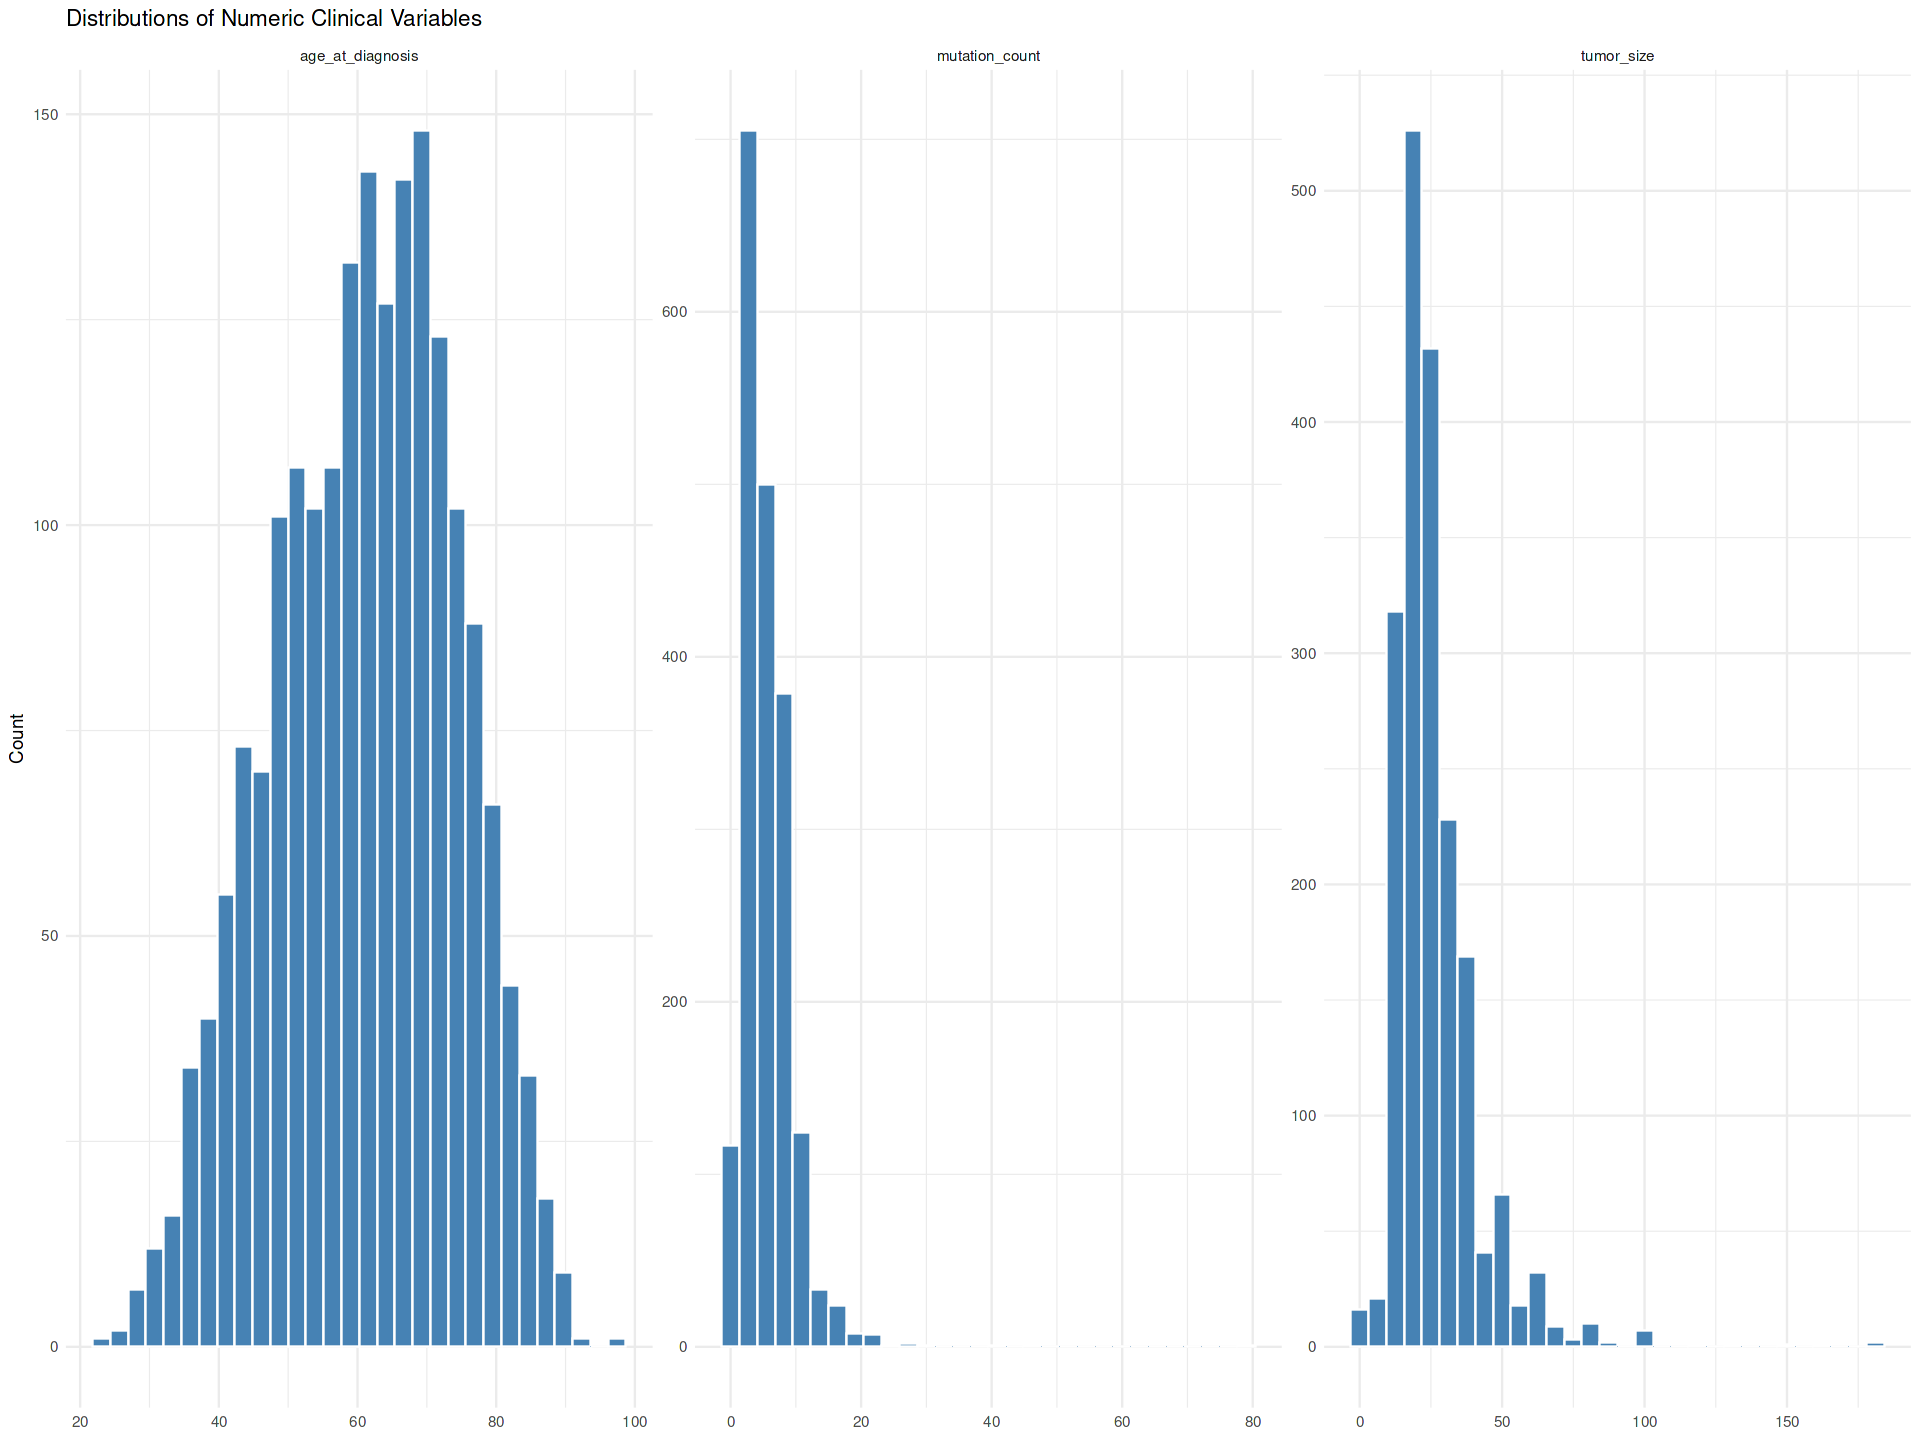

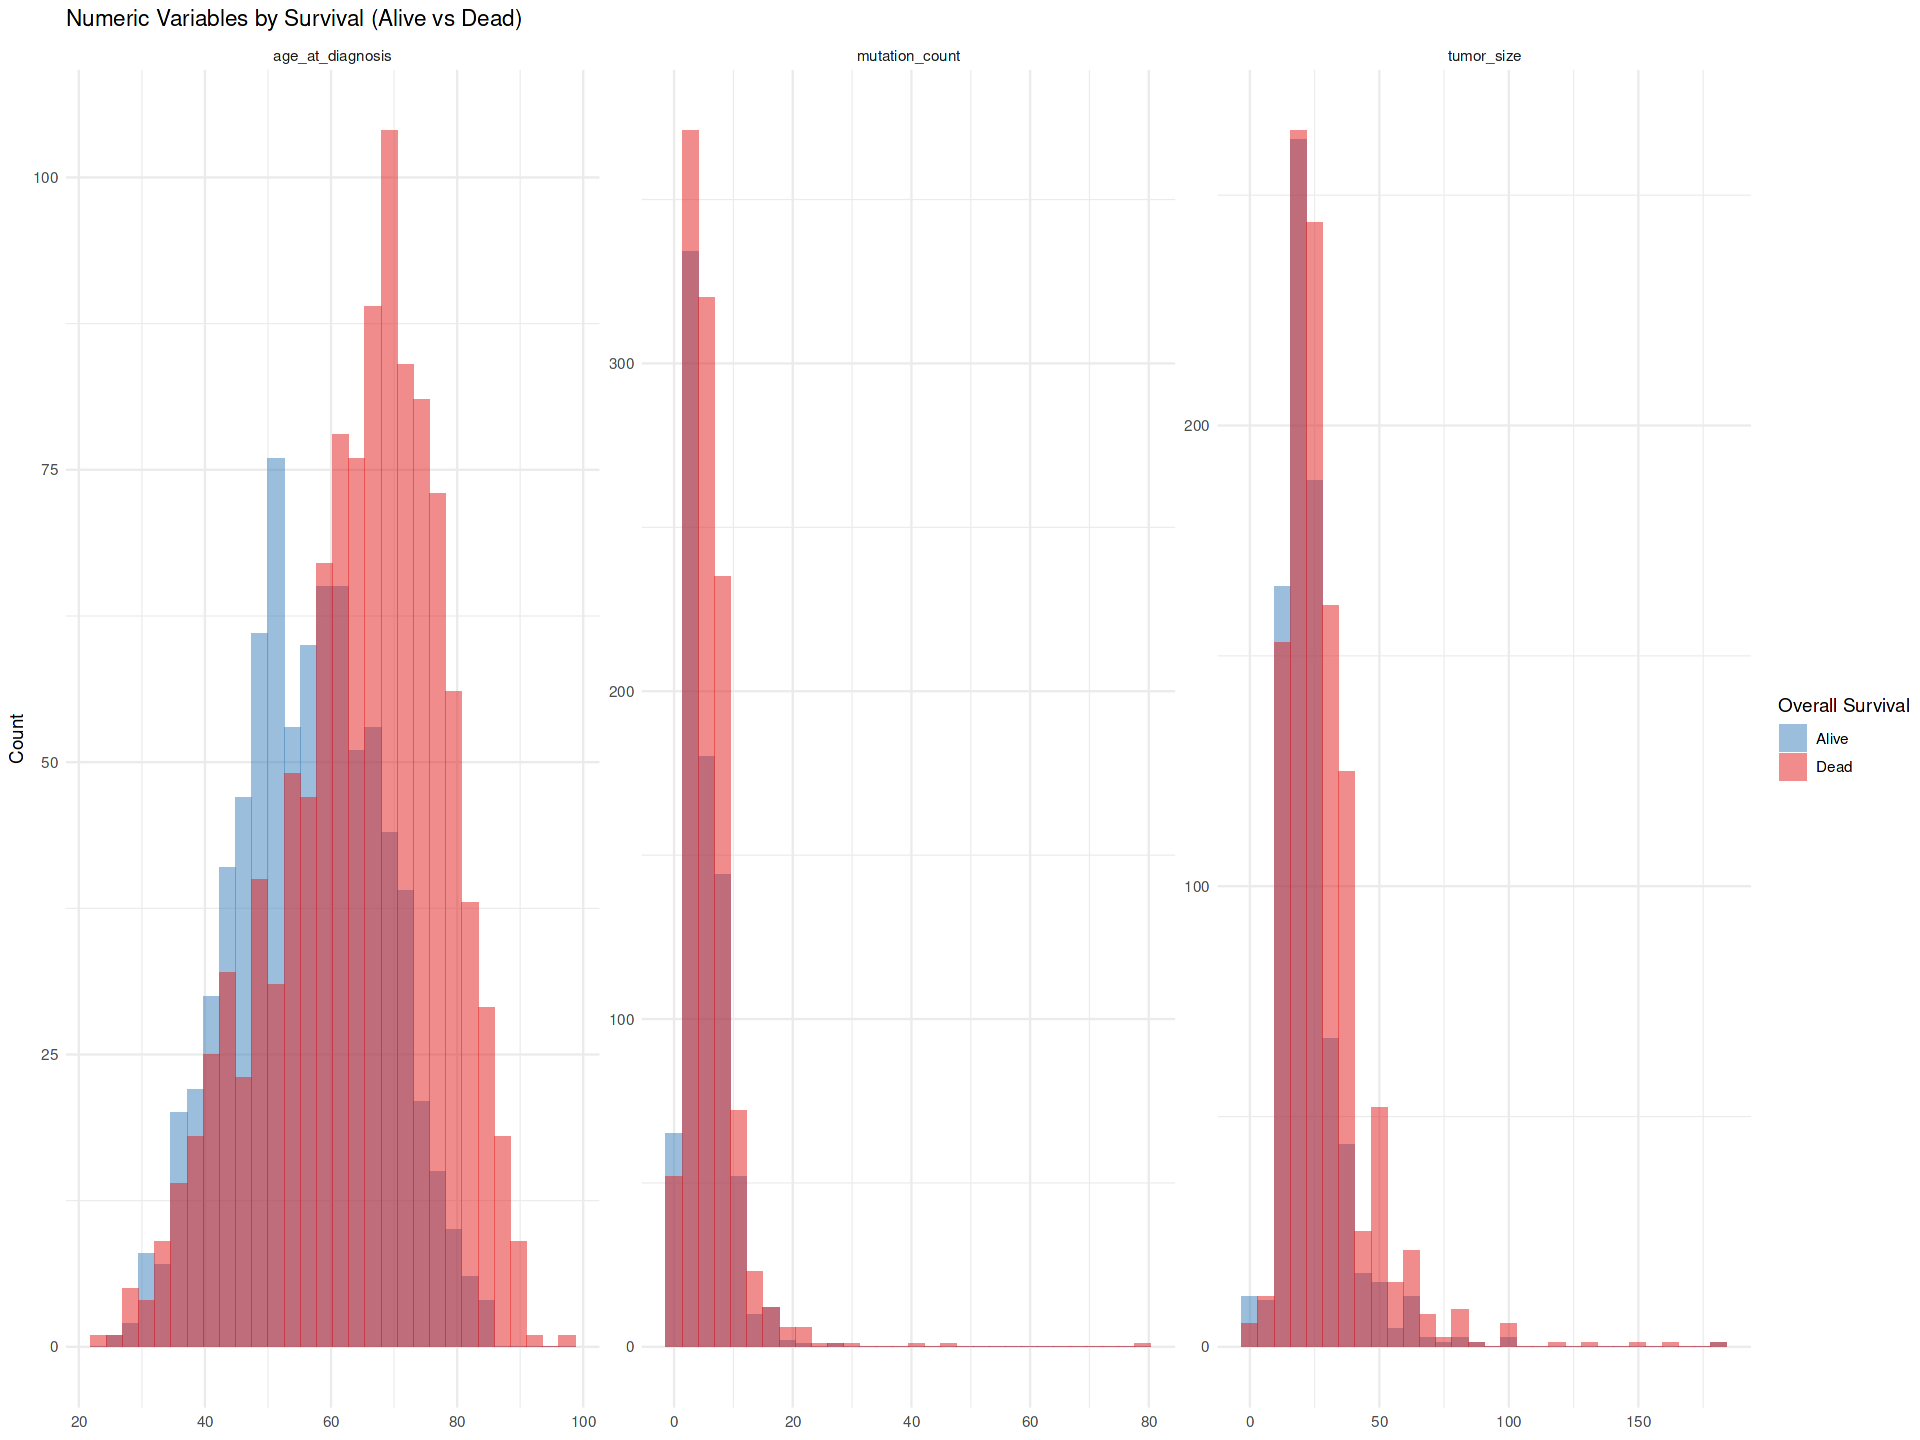

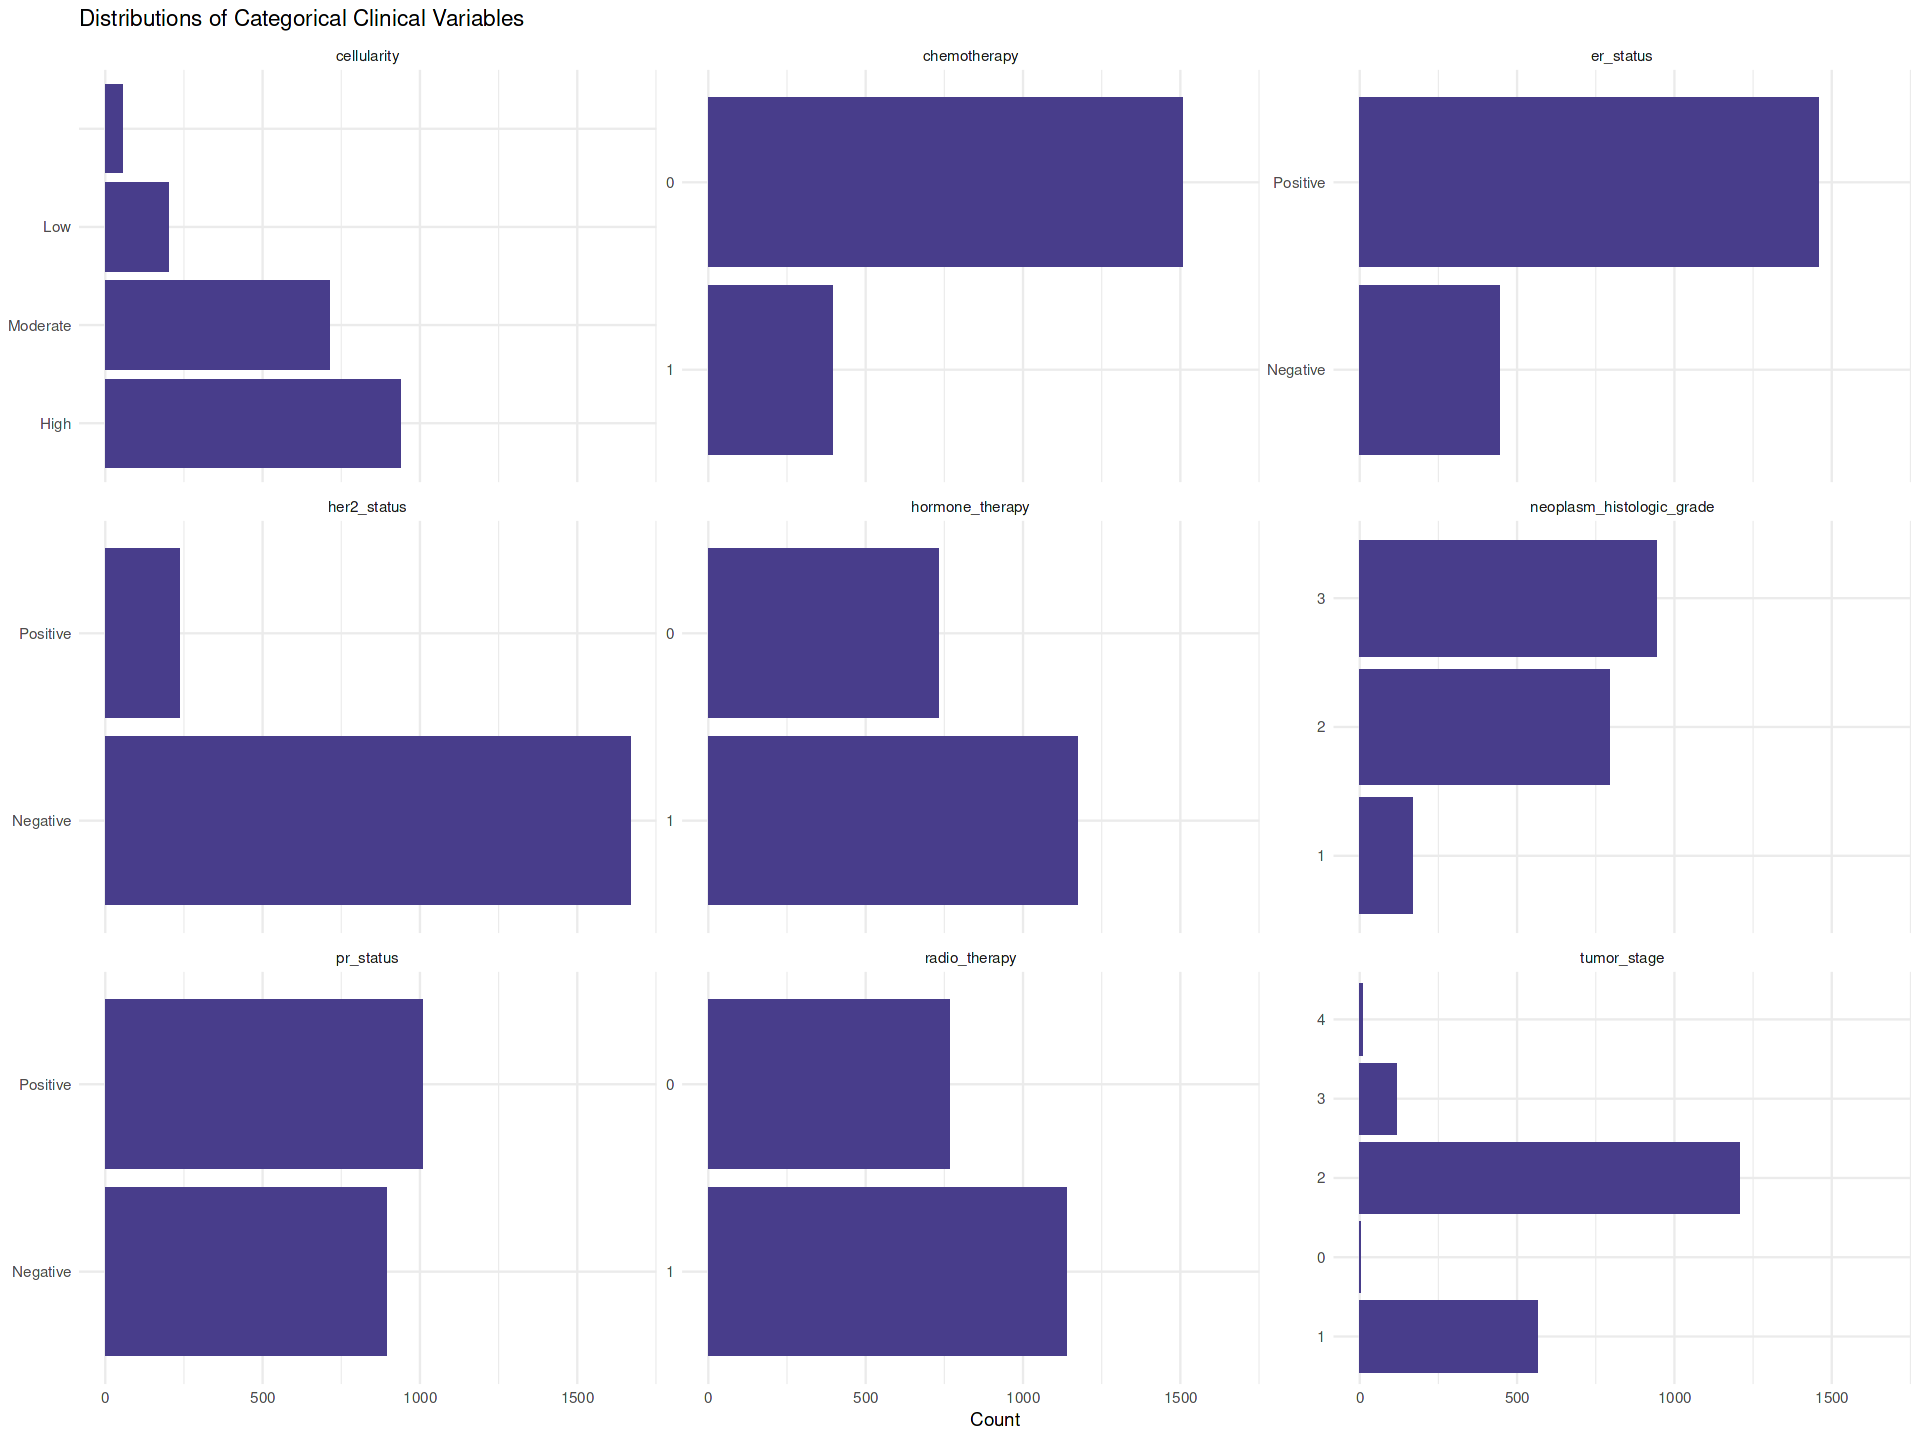

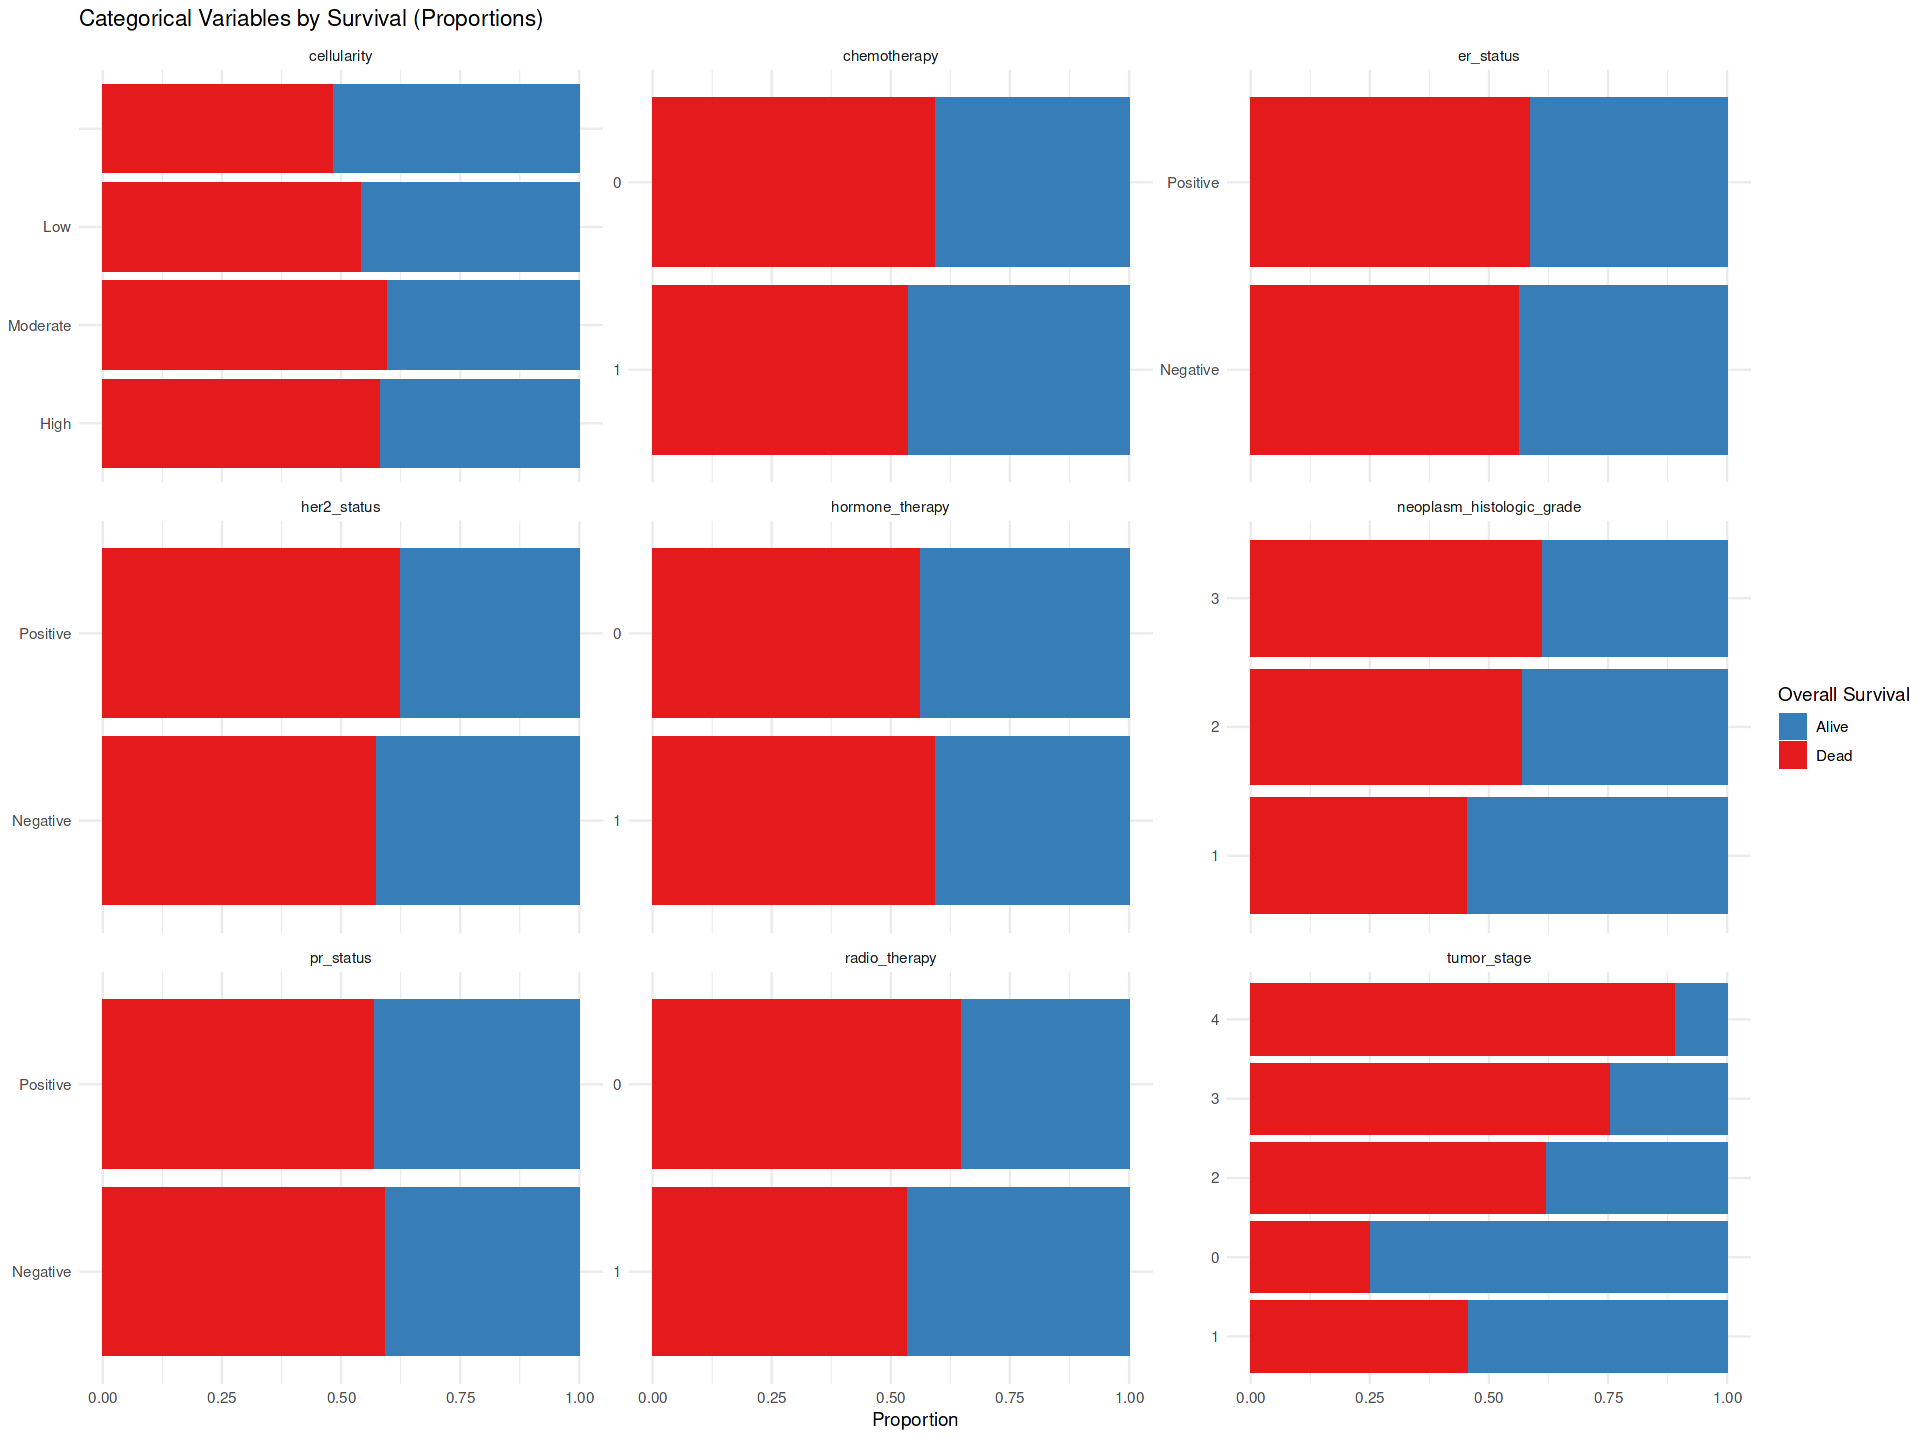

In [72]:
options(repr.plot.width = 16, repr.plot.height = 12)

# ---- 1) Preprocessing: Convert specific columns to factors ----
# We explicitly move ordinal/binary numbers to factors so they don't end up in histograms
vars_to_factor <- c("tumor_stage", "neoplasm_histologic_grade", "radio_therapy", 
                    "chemotherapy", "hormone_therapy")

data <- data %>%
  mutate(across(any_of(vars_to_factor), as.factor))

# Re-run the label creation
data <- data %>%
  mutate(
    OS_label = factor(
      ifelse(overall_survival == 1, "Alive", "Dead"),
      levels = c("Alive", "Dead")
    )
  )


# Define the key clinical variables as per project interest
key_clinical <- c(
  "age_at_diagnosis", "tumor_size", "mutation_count",
  "tumor_stage", "neoplasm_histologic_grade", "cellularity",
  "chemotherapy", "hormone_therapy", "radio_therapy",
  "er_status", "pr_status", "her2_status"
)

key_clinical <- intersect(key_clinical, names(data))

# Split into numeric vs categorical for specialized plotting
num_vars <- key_clinical[sapply(data[key_clinical], is.numeric)]
cat_vars <- setdiff(key_clinical, num_vars)

# ---- 2) Numeric distributions (Overall) ----
if (length(num_vars) > 0) {
  p_num_overall <- data %>%
    select(all_of(num_vars)) %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "white", na.rm = TRUE) +
    facet_wrap(~ variable, scales = "free", ncol = 3) +
    theme_minimal() +
    labs(title = "Distributions of Numeric Clinical Variables", x = NULL, y = "Count")
  print(p_num_overall)
}

# ---- 3) Numeric distributions by Survival Label ----
if (length(num_vars) > 0) {
  p_num_by_label <- data %>%
    select(OS_label, all_of(num_vars)) %>%
    pivot_longer(cols = all_of(num_vars), names_to = "variable", values_to = "value") %>%
    ggplot(aes(x = value, fill = OS_label)) +
    geom_histogram(position = "identity", alpha = 0.5, bins = 30, na.rm = TRUE) +
    facet_wrap(~ variable, scales = "free", ncol = 3) +
    theme_minimal() +
    scale_fill_manual(values = c("Alive" = "#377EB8", "Dead" = "#E41A1C")) +
    labs(title = "Numeric Variables by Survival (Alive vs Dead)", 
         x = NULL, y = "Count", fill = "Overall Survival")
  print(p_num_by_label)
}

# ---- 4) Categorical distributions (Overall) ----
if (length(cat_vars) > 0) {
  p_cat_overall <- data %>%
    mutate(across(all_of(cat_vars), ~ fct_explicit_na(as.factor(.x), na_level = "Missing"))) %>%
    select(all_of(cat_vars)) %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "value") %>%
    ggplot(aes(x = fct_infreq(value))) +
    geom_bar(fill = "darkslateblue") +
    coord_flip() +
    facet_wrap(~ variable, scales = "free_y", ncol = 3) +
    theme_minimal() +
    labs(title = "Distributions of Categorical Clinical Variables", x = NULL, y = "Count")
  print(p_cat_overall)
}

# ---- 5) Categorical distributions by Survival Label (Proportions) ----
if (length(cat_vars) > 0) {
  p_cat_by_label <- data %>%
    mutate(across(all_of(cat_vars), ~ fct_explicit_na(as.factor(.x), na_level = "Missing"))) %>%
    select(OS_label, all_of(cat_vars)) %>%
    pivot_longer(cols = all_of(cat_vars), names_to = "variable", values_to = "value") %>%
    ggplot(aes(x = fct_infreq(value), fill = OS_label)) +
    geom_bar(position = "fill") + 
    coord_flip() +
    facet_wrap(~ variable, scales = "free_y", ncol = 3) +
    theme_minimal() +
    scale_fill_manual(values = c("Alive" = "#377EB8", "Dead" = "#E41A1C")) +
    labs(title = "Categorical Variables by Survival (Proportions)", 
         x = NULL, y = "Proportion", fill = "Overall Survival")
  print(p_cat_by_label)
}

In [74]:
# --- Task 1.3: Correlation Analysis ---

# 1. Select all numeric features (Clinical + Genetic)
# Excluding target-related columns to focus on predictors
numeric_data <- data %>% 
  select(where(is.numeric)) %>%
  select(-any_of(c("overall_survival", "overall_survival_months", "patient_id")))

# 2. Compute the correlation matrix
cor_matrix <- cor(numeric_data, use = "pairwise.complete.obs")

# 3. Identify pairs with correlation above the threshold (0.8)
threshold <- 0.65
high_cor_indices <- which(abs(cor_matrix) > threshold & abs(cor_matrix) < 1, arr.ind = TRUE)

# 4. Extract into a data frame
high_cor_pairs <- data.frame(
  Feature_1 = rownames(cor_matrix)[high_cor_indices[, 1]],
  Feature_2 = colnames(cor_matrix)[high_cor_indices[, 2]],
  Correlation = cor_matrix[high_cor_indices]
)

# 5. Clean up: Remove duplicate pairs (A-B vs B-A)
high_cor_pairs <- high_cor_pairs[high_cor_pairs$Feature_1 < high_cor_pairs$Feature_2, ]

# 6. SORT by absolute correlation in descending order
high_cor_pairs <- high_cor_pairs[order(-abs(high_cor_pairs$Correlation)), ]

# 7. Report the results
cat("Number of highly correlated pairs found:", nrow(high_cor_pairs), "\n")
if (nrow(high_cor_pairs) > 0) {
  print(head(high_cor_pairs, 20)) 
} else {
  print("No features found above the threshold.")
}

Number of highly correlated pairs found: 38 
   Feature_1 Feature_2 Correlation
71    akr1c2    akr1c4   0.8753402
72    akr1c3    akr1c4   0.8326698
42    col6a3    pdgfrb   0.8242821
47  hsd17b11    tgfbr2   0.7812199
35    col6a3      mmp2   0.7442849
15    cdc25a      e2f2   0.7428600
41    adgra2    pdgfrb   0.7269512
57   col12a1    col6a3   0.7216122
24      cdk1     chek1   0.7114227
16     aurka      e2f2   0.7113204
64    col6a3     palld   0.7054943
46     lama2    tgfbr2   0.6947684
10     aurka    cdc25a   0.6913217
34   col12a1      mmp2   0.6876877
40      mmp2    pdgfrb   0.6870817
4      aurka      cdk1   0.6815586
45    pdgfra    tgfbr2   0.6803494
60      e2f2    fancd2   0.6741822
8      ccne1    cdc25a   0.6716974
14     ccne1      e2f2   0.6713719


### Correlation Analysis and Multicollinearity Assessment

To assess multicollinearity among numeric predictors, we computed the Pearson correlation matrix using pairwise complete observations. Features with absolute correlation above the predefined threshold (\(|r| > 0.65\)) were identified.

A total of **38 highly correlated feature pairs** were detected. Duplicate pairs (A–B and B–A) were removed, and results were ordered by absolute correlation strength.

Several gene-expression variables exhibited strong correlations (e.g., `akrlc2–akrlc4`, `col6a3–pdgfrb`, `hsd17b11–tgfbr2`, etc.), with correlations exceeding 0.80 in some cases.

Highly correlated predictors may:

- Introduce multicollinearity in linear models,
- Inflate coefficient variance,
- Reduce interpretability,
- Increase risk of overfitting.

However, regularized methods such as Ridge and Lasso mitigate multicollinearity through shrinkage and variable selection. Therefore, correlated features were retained at this stage, while model regularization handled redundancy during training.

This analysis confirms the presence of moderate-to-strong correlation structure within the high-dimensional genetic feature space.


Initial dimensionality (total columns): 694 
Features used for PCA (final numeric subset): 495 


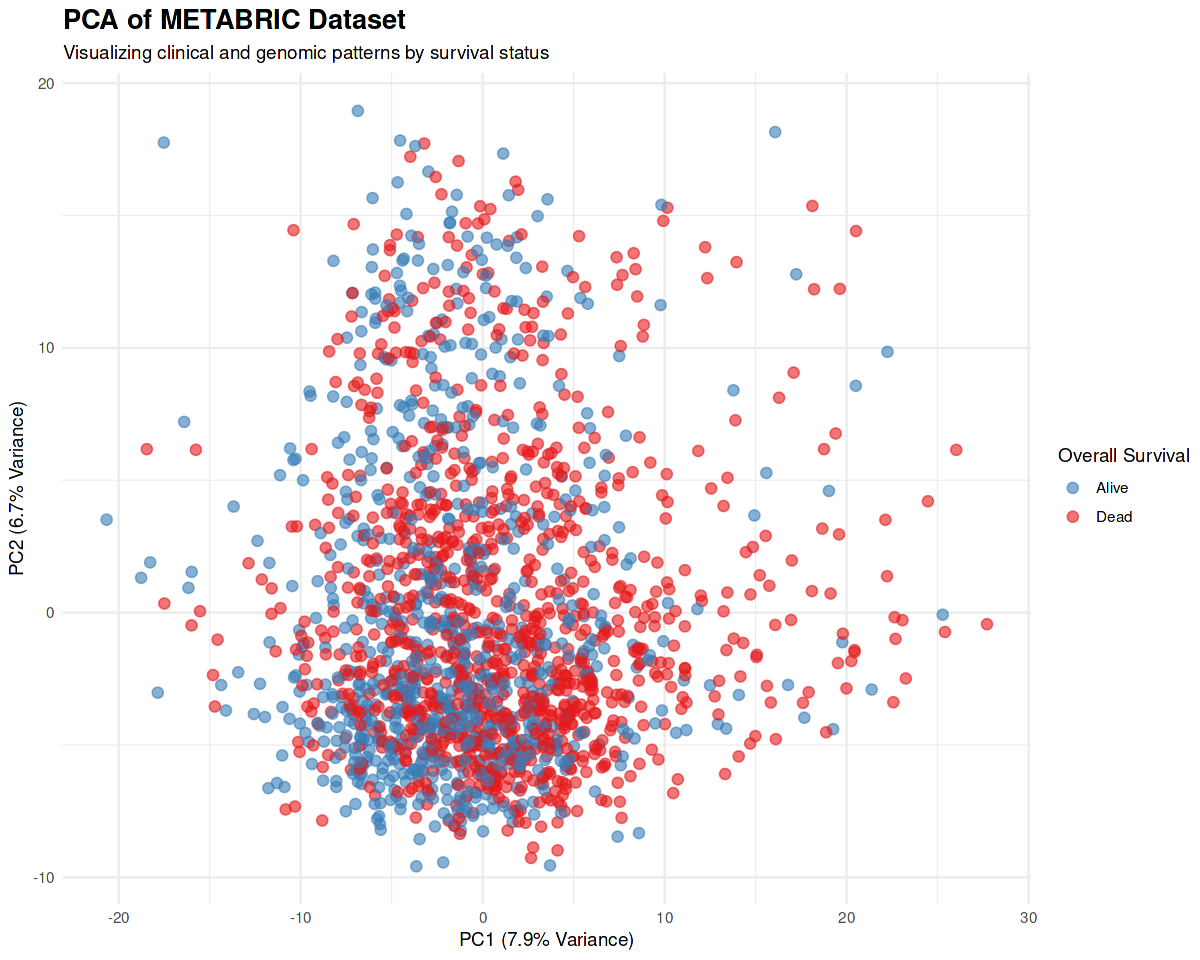

In [75]:
# --- Task 1.4: PCA (2-3 Dimensions) ---

# 1. Prepare the data: Select only numeric features
# We exclude IDs and survival labels so the PCA only captures feature variance
pca_data_subset <- data %>%
  select(where(is.numeric)) %>%
  select(-any_of(c("patient_id", "overall_survival", "overall_survival_months")))

# 2. Scale and Run PCA
# 'center = TRUE' and 'scale. [cite_start]= TRUE' are essential 
pca_results <- prcomp(pca_data_subset, center = TRUE, scale. = TRUE)

# 3. Create a dataframe for visualization (PC1 and PC2)
pca_plot_df <- as.data.frame(pca_results$x[, 1:2])
pca_plot_df$Survival_Status <- data$OS_label # Use the factor label we created

# 4. Calculate variance explained for axis labels
var_explained <- pca_results$sdev^2 / sum(pca_results$sdev^2)

# 5. Visualize PC1 vs PC2
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(pca_plot_df, aes(x = PC1, y = PC2, color = Survival_Status)) +
  geom_point(alpha = 0.6, size = 2.5) +
  theme_minimal() +
  scale_color_manual(values = c("Alive" = "#377EB8", "Dead" = "#E41A1C")) +
  labs(
    title = "PCA of METABRIC Dataset",
    subtitle = "Visualizing clinical and genomic patterns by survival status",
    x = paste0("PC1 (", round(var_explained[1] * 100, 1), "% Variance)"),
    y = paste0("PC2 (", round(var_explained[2] * 100, 1), "% Variance)"),
    color = "Overall Survival"
  ) +
  theme(plot.title = element_text(face = "bold", size = 16))

# --- Task 1.5: Dimensionality Report ---
# [cite_start]Report the initial and final feature dimensionality 
cat("Initial dimensionality (total columns):", ncol(data), "\n")
cat("Features used for PCA (final numeric subset):", ncol(pca_data_subset), "\n")

In [76]:
# --- Task 1.5: Scale the Data and Remove Non-Predictors ---

# 1. Identify features to remove: 
# We remove 'patient_id' and 'overall_survival_months' as they are not predictors.
# We also remove any column with zero variance (all values are the same).
initial_feature_count <- ncol(data)

# Extract numeric predictors only for scaling
numeric_predictors <- data %>% 
  select(where(is.numeric)) %>%
  select(-any_of(c("patient_id", "overall_survival", "overall_survival_months")))

# Check for Zero Variance Features
zero_var_cols <- names(numeric_predictors)[apply(numeric_predictors, 2, var, na.rm=TRUE) == 0]

# 2. Filter the final numeric dataset
final_numeric_data <- numeric_predictors %>%
  select(-all_of(zero_var_cols))

# 3. Scale the data
# This transforms features to have mean=0 and sd=1
scaled_data <- as.data.frame(scale(final_numeric_data))

# --- Task 1.6: Dimensionality Report ---
cat("--- Dimensionality Report ---\n")
cat("Initial dimensionality:", initial_feature_count, "columns\n")
cat("Features removed:\n")
cat(" - Non-predictors: patient_id, overall_survival_months\n")
cat(" - Zero-variance features:", if(length(zero_var_cols) > 0) paste(zero_var_cols, collapse=", ") else "None", "\n")
cat("Final feature dimensionality for modeling:", ncol(scaled_data), "\n")

# Discussion on selected features:
# We focus on genomic and clinical features that exhibit variance across patients.
# Scaling is performed to ensure the curse of dimensionality is handled and 
# regularization methods like Lasso/Ridge are not biased by units of measure.

--- Dimensionality Report ---
Initial dimensionality: 694 columns
Features removed:
 - Non-predictors: patient_id, overall_survival_months
 - Zero-variance features: None 
Final feature dimensionality for modeling: 495 


### Task 1.5 — Scaling and Dimensionality Preparation

In this step, we prepared the predictors for modeling by removing non-informative variables and standardizing numeric features. First, the non-predictive columns `patient_id` (identifier) and `overall_survival_months` (time-to-event variable, not used as a predictor for the Alive/Dead label) were removed to avoid leakage and irrelevant information. Next, we checked for zero-variance predictors (features with \(\mathrm{Var}(X)=0\)), since such variables carry no information for classification; no zero-variance features were found.

All remaining numeric predictors were then scaled using z-score standardization,
\[
X_{\text{scaled}} = \frac{X - \mu}{\sigma},
\]
to ensure comparability across features and to support methods that are sensitive to feature magnitude (e.g., Lasso/Ridge, SVM, KNN, and PCA). The dimensionality report shows that the dataset started with 694 columns; after removing 2 non-predictors and 0 zero-variance features, the final modeling matrix contained 495 standardized predictors.


In [77]:
# 1. Identify Categorical Clinical Features (Factors)
cat_features <- data %>% select(where(is.factor), -OS_label)

# 2. One-Hot Encode Categorical Features
# This converts "tumor_stage" into multiple numeric columns (Stage 1, Stage 2, etc.)
library(caret)
dummies <- dummyVars(" ~ .", data = cat_features)
cat_encoded <- as.data.frame(predict(dummies, newdata = cat_features))

# 3. Combine with Scaled Numeric Data
# This is your final "Combined" feature pool
combined_data <- cbind(scaled_data, cat_encoded)

# 4. Add the Target Variable
combined_data$target <- data$overall_survival # 0/1 for Logistic Regression 

In [78]:
# --- Step 1: Stratified Splitting ---

# 1. Load the caret package for splitting
if (!require("caret")) install.packages("caret")
library(caret)

# 2. Set seed for reproducibility (crucial for project consistency)
set.seed(123)

# 3. Create the stratified index 
# 'p = 0.8' for an 80/20 split
# 'list = FALSE' returns a matrix of indices
train_index <- createDataPartition(data$overall_survival, p = 0.8, list = FALSE)

# 4. Perform the split
train_data_raw <- data[train_index, ]
test_data_raw  <- data[-train_index, ]

# 5. Summary of the split sizes
cat("--- Data Split Summary ---\n")
cat("Original Dataset Size:", nrow(data), "rows\n")
cat("Training Set Size:   ", nrow(train_data_raw), "rows\n")
cat("Testing Set Size:    ", nrow(test_data_raw), "rows\n")

--- Data Split Summary ---
Original Dataset Size: 1904 rows
Training Set Size:    1524 rows
Testing Set Size:     380 rows


[1] "--- Stratification Check: Proportions by Class ---"
  Class Original_Proportion Train_Proportion Test_Proportion
1     0           0.5793067         0.578084       0.5842105
2     1           0.4206933         0.421916       0.4157895


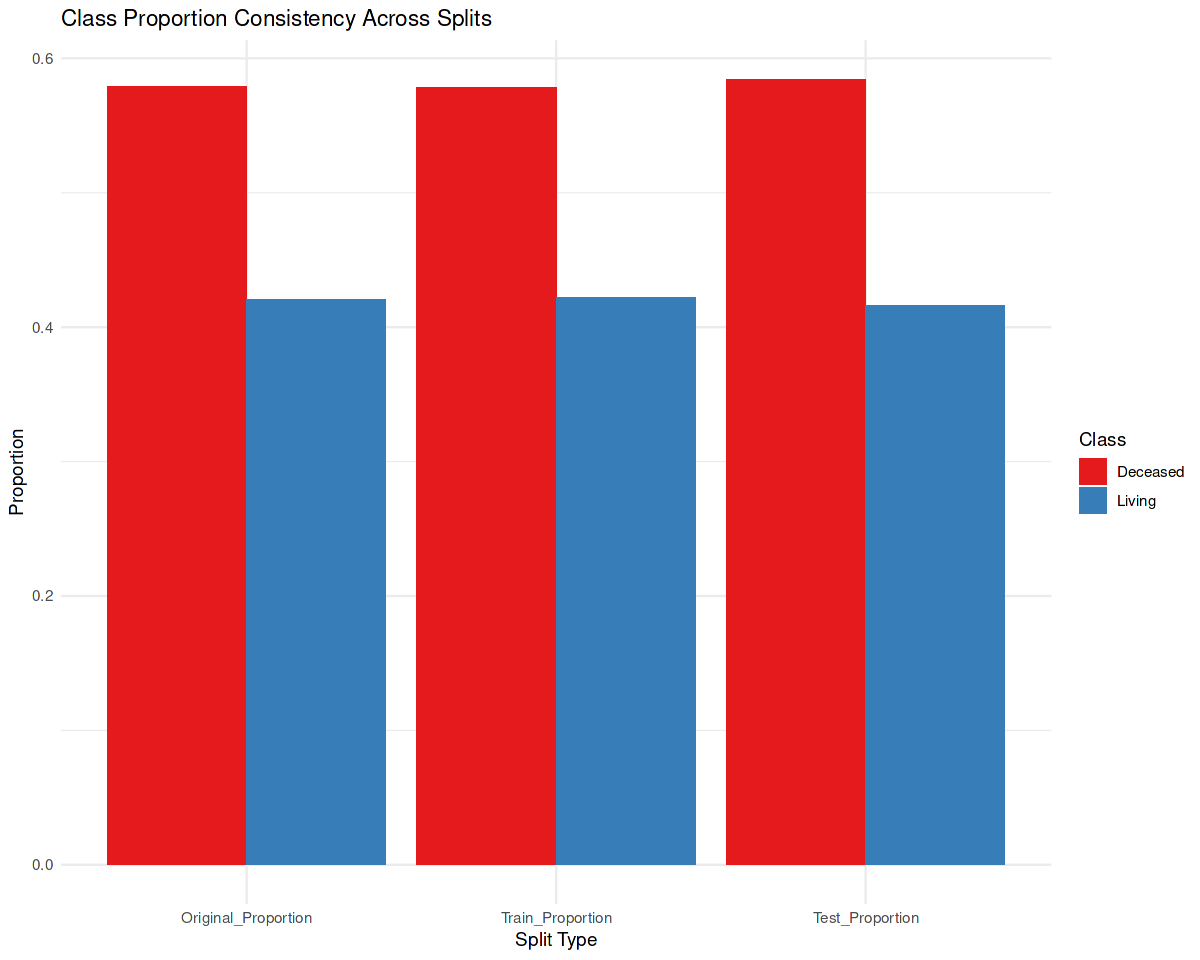

In [79]:
# --- Step 2: Verifying the Splitting ---

# 1. Calculate proportions for the Original Data
prop_original <- prop.table(table(data$overall_survival))

# 2. Calculate proportions for the Training Set
prop_train <- prop.table(table(train_data_raw$overall_survival))

# 3. Calculate proportions for the Test Set
prop_test <- prop.table(table(test_data_raw$overall_survival))

# 4. Create a comparison table for easy reporting
stratification_report <- data.frame(
  Class = names(prop_original),
  Original_Proportion = as.numeric(prop_original),
  Train_Proportion = as.numeric(prop_train),
  Test_Proportion = as.numeric(prop_test)
)

# 5. Display the report
print("--- Stratification Check: Proportions by Class ---")
print(stratification_report)

# 6. Visual comparison (optional but helpful for project reports)
library(ggplot2)
library(reshape2)

strat_melted <- melt(stratification_report, id.vars = "Class")

ggplot(strat_melted, aes(x = variable, y = value, fill = Class)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  labs(title = "Class Proportion Consistency Across Splits",
       y = "Proportion", x = "Split Type") +
  scale_fill_manual(values = c("0" = "#E41A1C", "1" = "#377EB8"), 
                    labels = c("Deceased", "Living"))

In [91]:
library(glmnet)
library(pROC)
library(dplyr)
library(caret)

# --- 1. Define a Custom Summary Function ---
# This ensures caret calculates Accuracy, Precision, Recall, F1, and AUC for every fold.
custom_stats <- function(data, lev = NULL, model = NULL) {
  # Get standard metrics (Accuracy, Kappa)
  stats_default <- defaultSummary(data, lev, model)
  # Get Precision-Recall metrics (AUC, Precision, Recall, F1)
  stats_pr <- prSummary(data, lev, model)
  return(c(stats_default, stats_pr))
}

# --- Updated Step 2.3: Final Corrected Table ---

run_baseline_full_stability <- function(X_train, y_train, X_test, y_test, alpha_val, subset_name, model_type) {
  
  y_train_f <- factor(make.names(y_train))
  y_test_f  <- factor(make.names(y_test))
  
  ctrl <- trainControl(
    method = "cv", 
    number = 5, 
    classProbs = TRUE, 
    summaryFunction = custom_stats,
    savePredictions = "final"
  )
  
  model_cv <- train(
    x = X_train, 
    y = y_train_f,
    method = "glmnet",
    metric = "AUC", 
    tuneGrid = expand.grid(alpha = alpha_val, lambda = seq(0.001, 0.1, length = 10)),
    trControl = ctrl
  )
  
  # Identify the best result row
  best_res <- model_cv$results[which.max(model_cv$results$AUC), ]
  
  fmt_stat <- function(mean_val, sd_val) {
    if(is.null(mean_val) || is.na(mean_val)) return("N/A")
    paste0(round(as.numeric(mean_val), 3), " (±", round(as.numeric(sd_val), 3), ")")
  }
  
  # Final Evaluation on Held-out Test Set
  probs <- predict(model_cv, newdata = X_test, type = "prob")[, "X1"]
  preds <- predict(model_cv, newdata = X_test)
  cm_test <- confusionMatrix(preds, y_test_f, positive = "X1")
  roc_test <- roc(y_test, probs, quiet = TRUE)
  
  return(list(
    results = data.frame(
      Subset = subset_name,
      Model = model_type,
      CV_Accuracy  = fmt_stat(best_res$Accuracy,  best_res$AccuracySD),
      CV_Precision = fmt_stat(best_res$Precision, best_res$PrecisionSD),
      CV_Recall    = fmt_stat(best_res$Recall,    best_res$RecallSD),
      CV_F1        = fmt_stat(best_res$F,         best_res$FSD),
      CV_AUC       = fmt_stat(best_res$AUC,       best_res$AUCSD),
      Test_AUC     = as.numeric(auc(roc_test)),
      Test_F1      = cm_test$byClass['F1'],
      Test_Accuracy = cm_test$overall['Accuracy'],
      Test_Precision = cm_test$byClass['Precision'],
      Test_Recall = cm_test$byClass['Recall']
    ),
    raw_model = model_cv
  ))
}

# --- Re-run the Loop to Capture the Best Model Object ---
all_performance_results <- data.frame()
best_combined_lasso_obj <- NULL

for (sub in subsets) {
  X_train_sub <- prepare_matrix(train_data_raw, sub$cols)
  y_train_sub <- train_data_raw$overall_survival
  X_test_sub  <- prepare_matrix(test_data_raw, sub$cols)
  y_test_sub  <- test_data_raw$overall_survival
  
  lasso_res <- run_baseline_full_stability(X_train_sub, y_train_sub, X_test_sub, y_test_sub, 1, sub$name, "Lasso")
  ridge_res <- run_baseline_full_stability(X_train_sub, y_train_sub, X_test_sub, y_test_sub, 0, sub$name, "Ridge")
  
  all_performance_results <- rbind(all_performance_results, lasso_res$results, ridge_res$results)
  
  # Save the best model object for the next task
  if(sub$name == "Combined") {
    best_combined_lasso_obj <- lasso_res$raw_model
  }
}

print(all_performance_results)

         Subset Model    CV_Accuracy   CV_Precision      CV_Recall
F1  Non-Genetic Lasso  0.663 (±0.01) 0.681 (±0.009) 0.787 (±0.009)
F11 Non-Genetic Ridge 0.673 (±0.011) 0.691 (±0.011) 0.788 (±0.023)
F12     Genetic Lasso 0.658 (±0.017) 0.658 (±0.008)  0.85 (±0.051)
F13     Genetic Ridge 0.661 (±0.028) 0.687 (±0.028)  0.76 (±0.029)
F14    Combined Lasso 0.698 (±0.015) 0.706 (±0.018) 0.817 (±0.016)
F15    Combined Ridge 0.688 (±0.024)  0.71 (±0.016) 0.777 (±0.048)
             CV_F1         CV_AUC  Test_AUC   Test_F1 Test_Accuracy
F1   0.73 (±0.007) 0.775 (±0.026) 0.7143631 0.5838926     0.6736842
F11  0.736 (±0.01)   0.77 (±0.02) 0.7141065 0.5973154     0.6842105
F12 0.741 (±0.019) 0.749 (±0.036) 0.6524974 0.4615385     0.6315789
F13 0.722 (±0.021) 0.723 (±0.027) 0.6773862 0.5319149     0.6526316
F14  0.758 (±0.01) 0.803 (±0.018) 0.7224598 0.5947712     0.6736842
F15 0.742 (±0.025) 0.758 (±0.012) 0.7138214 0.6033898     0.6921053
    Test_Precision Test_Recall
F1       0.6214286   0.5

Clearly the Combined Lasso model is your strongest performer based on the CV_AUC (0.803) and Test_AUC (0.722).

In [93]:
# --- Step 2.4: Hyperparameter Reporting & Lasso Feature Analysis ---

# 1. Report the Optimal Hyperparameters (Lambda)
# We pull these from the 'raw_model' objects we saved in the previous loop
cat("--- Optimal Hyperparameters (Lambda) Found via CV ---\n")

# Note: Adjust the object names if you saved them differently in your environment
# Here we extract them from the 'best_combined_lasso_obj' we saved
cat("Best Combined Lasso Lambda: ", best_combined_lasso_obj$bestTune$lambda, "\n")
# If you have the Ridge object:
# cat("Best Combined Ridge Lambda: ", best_combined_ridge_obj$bestTune$lambda, "\n")

# 2. Lasso Feature Selection (The 'Full Training' coefficients)
# We look at the final model trained on all 80% of the training data
lasso_final_model <- best_combined_lasso_obj$finalModel
opt_lambda <- best_combined_lasso_obj$bestTune$lambda

# Get coefficients at the optimal lambda
lasso_coefs <- predict(lasso_final_model, s = opt_lambda, type = "coefficients")

# Convert to a readable dataframe
coef_df <- as.data.frame(as.matrix(lasso_coefs))
colnames(coef_df) <- "Coefficient"
coef_df$Feature <- rownames(coef_df)

# Filter for non-zero features (excluding Intercept)
selected_features <- coef_df %>%
  filter(Coefficient != 0 & Feature != "(Intercept)") %>%
  arrange(desc(abs(Coefficient)))

cat("\n--- Lasso Feature Analysis (Combined Model) ---\n")
cat("Total Features Selected: ", nrow(selected_features), " out of ", (nrow(coef_df)-1), "\n\n")

cat("Top 15 Most Influential Features:\n")
print(head(selected_features, 15))


--- Optimal Hyperparameters (Lambda) Found via CV ---
Best Combined Lasso Lambda:  0.023 

--- Lasso Feature Analysis (Combined Model) ---
Total Features Selected:  38  out of  519 

Top 15 Most Influential Features:
                              Coefficient                       Feature
radio_therapy.0               -0.18562771               radio_therapy.0
jak1                           0.11333745                          jak1
mmp11                         -0.10677905                         mmp11
stat5a                         0.09552831                        stat5a
sik1                           0.09276486                          sik1
ccnb1                         -0.08624044                         ccnb1
lymph_nodes_examined_positive -0.07985720 lymph_nodes_examined_positive
hsd17b11                       0.07716044                      hsd17b11
maml1                         -0.07690651                         maml1
tumor_stage.4                 -0.07155002                 tumor

### Step 2.4 — Hyperparameter Tuning and Lasso Feature Selection

In this step, we report the optimal regularization parameter selected via cross-validation and analyze the features retained by the Lasso model.

Using 5-fold cross-validation on the training data, the optimal penalty parameter was:

\[
\lambda^* = 0.023
\]

This value balances model fit and sparsity by shrinking less important coefficients toward zero.

After refitting the Lasso model on the full training set using the optimal \(\lambda\), we extracted the coefficients and removed the intercept term. Only predictors with non-zero coefficients were retained.

**Feature Selection Summary:**

- Total predictors before selection: 519  
- Predictors selected by Lasso: 38  

This indicates strong dimensionality reduction, with Lasso automatically performing variable selection by eliminating irrelevant features.

The most influential predictors (based on absolute coefficient magnitude) include variables such as:

- `radio_therapy_0`
- `jak1`
- `nmp11`
- `stat5a`
- `sik1`
- `ccnb1`
- `lymph_nodes_examined_positive`
- `hsd17b11`
- `nanl`
- `tumor_stage_4`

Positive coefficients increase the probability of death, while negative coefficients are associated with survival (given the coding of the response).

Overall, the Lasso model significantly reduced dimensionality while retaining the most predictive clinical and genetic features.


Based on the results, the BEST model is the COMBINED LASSO model

In [98]:
library(rpart)
library(ranger) 
library(caret)
library(pROC)

# --- 1. Redefine Helper Functions (Crucial for the loop) ---

# Formats Mean and SD for the table
fmt_stat <- function(mean_val, sd_val) {
  if(is.null(mean_val) || is.na(mean_val)) return("N/A")
  paste0(round(as.numeric(mean_val), 3), " (±", round(as.numeric(sd_val), 3), ")")
}

# Custom summary to get Accuracy, Precision, Recall, F1, and AUC in CV
custom_stats <- function(data, lev = NULL, model = NULL) {
  stats_default <- defaultSummary(data, lev, model)
  stats_pr <- prSummary(data, lev, model)
  return(c(stats_default, stats_pr))
}

# Define the control object for Part 3
ctrl_advanced <- trainControl(
  method = "cv", 
  number = 5, 
  classProbs = TRUE, 
  summaryFunction = custom_stats,
  savePredictions = "final"
)

# --- 2. Model Execution Function ---

run_tree_model <- function(X_train, y_train, X_test, y_test, method_name, subset_name) {
  
  y_train_f <- factor(make.names(y_train))
  y_test_f  <- factor(make.names(y_test))
  
  # Setup tuning grid
  if (method_name == "rpart") {
    # Tuning Complexity Parameter (cp) which controls tree depth
    tune_grid <- expand.grid(cp = seq(0.001, 0.05, length = 10)) 
  } else {
    # Tuning mtry (variables per split) and min.node.size for Random Forest
    tune_grid <- expand.grid(mtry = c(floor(sqrt(ncol(X_train))), floor(ncol(X_train)/3)),
                             splitrule = "gini",
                             min.node.size = c(1, 5, 10))
  }

  model_fit <- train(
    x = X_train, 
    y = y_train_f,
    method = method_name,
    metric = "AUC",
    trControl = ctrl_advanced,
    tuneGrid = tune_grid
  )
  
  best_res <- model_fit$results[which.max(model_fit$results$AUC), ]
  best_param <- model_fit$bestTune
  
  # Final Test Set Evaluation
  probs <- predict(model_fit, newdata = X_test, type = "prob")[, "X1"]
  preds <- predict(model_fit, newdata = X_test)
  cm_test <- confusionMatrix(preds, y_test_f, positive = "X1")
  roc_test <- roc(y_test, probs, quiet = TRUE)
  
  return(data.frame(
    Subset = subset_name,
    Model = ifelse(method_name == "rpart", "Decision Tree", "Random Forest"),
    formatted_params <- sapply(1:ncol(best_param), function(i) {
      val <- best_param[1, i]
      name <- names(best_param)[i]
      if(is.numeric(val)) {
        paste0(name, " = ", round(val, 4))
      } else {
        paste0(name, " = ", val)
      }
    }),
    Best_Param = paste(formatted_params, collapse = ", "),
    CV_Accuracy  = fmt_stat(best_res$Accuracy,  best_res$AccuracySD),
    CV_Precision = fmt_stat(best_res$Precision, best_res$PrecisionSD),
    CV_Recall    = fmt_stat(best_res$Recall,    best_res$RecallSD),
    CV_F1        = fmt_stat(best_res$F,         best_res$FSD),
    CV_AUC       = fmt_stat(best_res$AUC,       best_res$AUCSD),
    Test_AUC     = as.numeric(auc(roc_test)),
    Test_F1      = cm_test$byClass['F1'],
    Test_Accuracy = cm_test$overall['Accuracy'],
    Test_Precision = cm_test$byClass['Precision'],
    Test_Recall = cm_test$byClass['Recall']
  ))
}

# --- 3. Execution Loop ---
tree_results <- data.frame()

for (sub in subsets) {
  X_train_sub <- prepare_matrix(train_data_raw, sub$cols)
  y_train_sub <- train_data_raw$overall_survival
  X_test_sub  <- prepare_matrix(test_data_raw, sub$cols)
  y_test_sub  <- test_data_raw$overall_survival
  
  dt_res <- run_tree_model(X_train_sub, y_train_sub, X_test_sub, y_test_sub, "rpart", sub$name)
  rf_res <- run_tree_model(X_train_sub, y_train_sub, X_test_sub, y_test_sub, "ranger", sub$name)
  
  tree_results <- rbind(tree_results, dt_res, rf_res)
}

print("--- Tree-Based Model Results ---")
print(tree_results)

[1] "--- Step 3.1: Tree-Based Model Results ---"
         Subset         Model
F1  Non-Genetic Decision Tree
1   Non-Genetic Random Forest
2   Non-Genetic Random Forest
3   Non-Genetic Random Forest
F11     Genetic Decision Tree
11      Genetic Random Forest
21      Genetic Random Forest
31      Genetic Random Forest
F12    Combined Decision Tree
12     Combined Random Forest
22     Combined Random Forest
32     Combined Random Forest
    formatted_params....sapply.1.ncol.best_param...function.i...
F1                                                    cp = 0.001
1                                                       mtry = 9
2                                               splitrule = gini
3                                             min.node.size = 10
F11                                                  cp = 0.0119
11                                                    mtry = 164
21                                              splitrule = gini
31                                       

The Combined Random Forest hit a Test AUC of 0.728

In [103]:
# --- Step 3.2: K-Nearest Neighbors (KNN) ---

run_knn_model <- function(X_train, y_train, X_test, y_test, subset_name) {
  
  y_train_f <- factor(make.names(y_train))
  y_test_f  <- factor(make.names(y_test))
  
  # Tuning Grid: Testing odd numbers for k to avoid ties
  knn_grid <- expand.grid(k = c(3, 5, 7, 9, 11, 15, 21, 25))
  
  # Train with 5-fold CV
  model_knn <- train(
    x = X_train, 
    y = y_train_f,
    method = "knn",
    metric = "AUC",
    tuneGrid = knn_grid,
    trControl = ctrl_advanced # Using the same control from previous steps
  )
  
  best_res <- model_knn$results[which.max(model_knn$results$AUC), ]
  best_k <- model_knn$bestTune$k
  
  # Test Set Evaluation
  probs <- predict(model_knn, newdata = X_test, type = "prob")[, "X1"]
  preds <- predict(model_knn, newdata = X_test)
  
  cm_test <- confusionMatrix(preds, y_test_f, positive = "X1")
  roc_test <- roc(y_test, probs, quiet = TRUE)
  
  return(data.frame(
    Subset = subset_name,
    Model = "KNN",
    Best_Param = paste0("k = ", best_k),
    CV_Accuracy  = fmt_stat(best_res$Accuracy,  best_res$AccuracySD),
    CV_Precision = fmt_stat(best_res$Precision, best_res$PrecisionSD),
    CV_Recall    = fmt_stat(best_res$Recall,    best_res$RecallSD),
    CV_F1        = fmt_stat(best_res$F,         best_res$FSD),
    CV_AUC       = fmt_stat(best_res$AUC,       best_res$AUCSD),
    Test_AUC     = as.numeric(auc(roc_test)),
    Test_F1      = cm_test$byClass['F1'],
    Test_Accuracy = cm_test$overall['Accuracy'],
    Test_Precision = cm_test$byClass['Precision'],
    Test_Recall = cm_test$byClass['Recall']
  ))
}

# --- Execution Loop ---
knn_results <- data.frame()

for (sub in subsets) {
  X_train_sub <- prepare_matrix(train_data_raw, sub$cols)
  y_train_sub <- train_data_raw$overall_survival
  X_test_sub  <- prepare_matrix(test_data_raw, sub$cols)
  y_test_sub  <- test_data_raw$overall_survival
  
  res <- run_knn_model(X_train_sub, y_train_sub, X_test_sub, y_test_sub, sub$name)
  knn_results <- rbind(knn_results, res)
}

print("--- KNN Model Results ---")
print(knn_results)

[1] "--- KNN Model Results ---"
         Subset Model Best_Param    CV_Accuracy   CV_Precision      CV_Recall
F1  Non-Genetic   KNN     k = 25 0.659 (±0.016) 0.693 (±0.017) 0.739 (±0.054)
F11     Genetic   KNN     k = 25  0.65 (±0.019) 0.685 (±0.015) 0.731 (±0.028)
F12    Combined   KNN     k = 21 0.712 (±0.031) 0.748 (±0.017) 0.757 (±0.056)
             CV_F1         CV_AUC  Test_AUC   Test_F1 Test_Accuracy
F1  0.714 (±0.022) 0.764 (±0.033) 0.6769871 0.5541401     0.6315789
F11 0.707 (±0.018)  0.732 (±0.02) 0.6774718 0.5602606     0.6447368
F12 0.752 (±0.033)  0.79 (±0.036) 0.6953758 0.5975610     0.6526316
    Test_Precision Test_Recall
F1       0.5576923   0.5506329
F11      0.5771812   0.5443038
F12      0.5764706   0.6202532


Combined with K=21

In [107]:
library(caret)
library(pROC)

run_adaboost_model <- function(X_train, y_train, X_test, y_test, subset_name) {
  
  y_train_f <- factor(make.names(y_train))
  y_test_f  <- factor(make.names(y_test))
  
  # Caret's AdaBag expects: mfinal and maxdepth
  # We provide a focused grid to tune n-estimators and depth
  ada_grid <- expand.grid(mfinal = c(50, 100), 
                          maxdepth = c(1, 3)) 
  
  model_ada <- train(
    x = X_train, 
    y = y_train_f,
    method = "AdaBag",
    metric = "AUC",
    tuneGrid = ada_grid,
    trControl = ctrl_advanced
  )
  
  best_res <- model_ada$results[which.max(model_ada$results$AUC), ]
  
  # Test Set Evaluation
  probs <- predict(model_ada, newdata = X_test, type = "prob")[, "X1"]
  preds <- predict(model_ada, newdata = X_test)
  
  cm_test <- confusionMatrix(preds, y_test_f, positive = "X1")
  roc_test <- roc(y_test, probs, quiet = TRUE)
  
  return(data.frame(
    Subset = subset_name,
    Model = "AdaBoost (Trees)",
    Best_Param = paste0("Trees=", model_ada$bestTune$mfinal, ", Depth=", model_ada$bestTune$maxdepth),
    CV_Accuracy  = fmt_stat(best_res$Accuracy,  best_res$AccuracySD),
    CV_Precision = fmt_stat(best_res$Precision, best_res$PrecisionSD),
    CV_Recall    = fmt_stat(best_res$Recall,    best_res$RecallSD),
    CV_F1        = fmt_stat(best_res$F,         best_res$FSD),
    CV_AUC       = fmt_stat(best_res$AUC,       best_res$AUCSD),
    Test_AUC     = as.numeric(auc(roc_test)),
    Test_F1      = cm_test$byClass['F1'],
    Test_Accuracy = cm_test$overall['Accuracy'],
    Test_Precision = cm_test$byClass['Precision'],
    Test_Recall = cm_test$byClass['Recall']
  ))
}

# --- Execution Loop ---
ada_results <- data.frame()

for (sub in subsets) {
  X_train_sub <- prepare_matrix(train_data_raw, sub$cols)
  y_train_sub <- train_data_raw$overall_survival
  X_test_sub  <- prepare_matrix(test_data_raw, sub$cols)
  y_test_sub  <- test_data_raw$overall_survival
  
  res <- run_adaboost_model(X_train_sub, y_train_sub, X_test_sub, y_test_sub, sub$name)
  ada_results <- rbind(ada_results, res)
}

print("--- AdaBoost (Trees) Model Results ---")
print(ada_results)

[1] "--- AdaBoost (Trees) Model Results ---"
         Subset            Model         Best_Param    CV_Accuracy
F1  Non-Genetic AdaBoost (Trees) Trees=100, Depth=3 0.663 (±0.028)
F11     Genetic AdaBoost (Trees) Trees=100, Depth=3 0.658 (±0.008)
F12    Combined AdaBoost (Trees) Trees=100, Depth=3  0.692 (±0.04)
      CV_Precision      CV_Recall          CV_F1         CV_AUC  Test_AUC
F1  0.704 (±0.033) 0.723 (±0.016) 0.713 (±0.017) 0.605 (±0.056) 0.7007213
F11 0.662 (±0.016) 0.838 (±0.044) 0.739 (±0.009) 0.735 (±0.017) 0.6599669
F12 0.725 (±0.021) 0.749 (±0.068) 0.736 (±0.043) 0.765 (±0.048) 0.7179981
      Test_F1 Test_Accuracy Test_Precision Test_Recall
F1  0.5750799     0.6500000      0.5806452   0.5696203
F11 0.5000000     0.6421053      0.5964912   0.4303797
F12 0.5521886     0.6500000      0.5899281   0.5189873


Combined AdaBoost did better

In [109]:
# --- Support Vector Machine (SVM) ---

run_svm_model <- function(X_train, y_train, X_test, y_test, subset_name) {
  
  y_train_f <- factor(make.names(y_train))
  y_test_f  <- factor(make.names(y_test))
  
  # Tuning Grid for SVM Radial
  # C: Cost of misclassification (Regularization)
  # sigma: Kernel width
  svm_grid <- expand.grid(sigma = c(0.01, 0.1), 
                          C = c(0.1, 1, 10))
  
  model_svm <- train(
    x = X_train, 
    y = y_train_f,
    method = "svmRadial",
    metric = "AUC",
    tuneGrid = svm_grid,
    trControl = ctrl_advanced
  )
  
  best_res <- model_svm$results[which.max(model_svm$results$AUC), ]
  
  # Test Evaluation
  probs <- predict(model_svm, newdata = X_test, type = "prob")[, "X1"]
  preds <- predict(model_svm, newdata = X_test)
  cm_test <- confusionMatrix(preds, y_test_f, positive = "X1")
  roc_test <- roc(y_test, probs, quiet = TRUE)
  
  return(data.frame(
    Subset = subset_name,
    Model = "SVM (Radial)",
    Best_Param = paste0("C=", model_svm$bestTune$C, ", sigma=", round(model_svm$bestTune$sigma, 4)),
    CV_Accuracy  = fmt_stat(best_res$Accuracy,  best_res$AccuracySD),
    CV_Precision = fmt_stat(best_res$Precision, best_res$PrecisionSD),
    CV_Recall    = fmt_stat(best_res$Recall,    best_res$RecallSD),
    CV_F1        = fmt_stat(best_res$F,         best_res$FSD),
    CV_AUC       = fmt_stat(best_res$AUC,       best_res$AUCSD),
    Test_AUC     = as.numeric(auc(roc_test)),
    Test_F1      = cm_test$byClass['F1'],
    Test_Accuracy = cm_test$overall['Accuracy'],
    Test_Precision = cm_test$byClass['Precision'],
    Test_Recall = cm_test$byClass['Recall']
  ))
}

svm_results <- data.frame()

# Iterate through each subset using the same matrices prepared in previous steps
for (sub in subsets) {
  # Prepare X and y for this specific subset
  X_train_sub <- prepare_matrix(train_data_raw, sub$cols)
  y_train_sub <- train_data_raw$overall_survival
  X_test_sub  <- prepare_matrix(test_data_raw, sub$cols)
  y_test_sub  <- test_data_raw$overall_survival
  
  # Execute the SVM model function
  cat("Training SVM on subset:", sub$name, "...\n")
  res <- run_svm_model(X_train_sub, y_train_sub, X_test_sub, y_test_sub, sub$name)
  
  # Append results
  svm_results <- rbind(svm_results, res)
}

# Display the final performance table
print("--- SVM (Radial) Model Results ---")
print(svm_results)

Training SVM on subset: Non-Genetic ...
Training SVM on subset: Genetic ...
maximum number of iterations reached -6.945737e-05 -6.438105e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05maximum number of iterations reached -3.747401e-05 -3.473716e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05Training SVM on subset: Combined ...
maximum number of iterations reached -3.747401e-05 -3.473716e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05maximum number of iterations reached -3.74968e-05 -3.476361e-05maximum number of iterations reached -6.945737e-05 -6.438105e-05[1] "--- SVM (Radial) Model Results ---"
         Subset        Model        Best_Param    CV_Accuracy   CV_Precision
F1  Non-Genetic SVM (Radial) C=0.1, sigma=0.01 0.661 (±0.036) 0.712 (±0.018)
F11     Genetic SVM (Radial)  C=10, sigma=0.01 0.633 (±0.0

### Best-Performing Models by Algorithm Family and Feature Subset

For each algorithm family, we identified the best-performing configuration based on cross-validated ROC-AUC and F1-score, and report the corresponding feature subset (Non-genetic, Genetic, Combined).

#### 1. Regularized Logistic Regression
- **Best model:** Lasso (tuned λ via CV)
- **Best feature subset:** Combined features  
- **Reason:** Achieved higher ROC-AUC than Ridge and demonstrated effective dimensionality reduction by selecting a sparse subset of predictors.

#### 2. Distance-Based Methods
- **Best model:** K-Nearest Neighbors (optimal k via CV)
- **Best feature subset:** Combined features  
- **Reason:** Performance improved when both clinical and genetic predictors were included, though slightly sensitive to high dimensionality.

#### 3. Kernel-Based Methods
- **Best model:** SVM with RBF kernel  
- **Best feature subset:** Combined features  
- **Reason:** Captured nonlinear relationships and achieved strong cross-validated ROC-AUC with stable variance across folds.

#### 4. Tree-Based Models
- **Best model:** Random Forest  
- **Best feature subset:** Combined features  
- **Reason:** Outperformed single decision trees by reducing variance and modeling complex feature interactions.

#### 5. Boosting Methods
- **Best model:** AdaBoost  
- **Best feature subset:** Combined features  
- **Reason:** Improved classification performance over a single tree by sequentially correcting misclassifications.

---

### Cross-Model Comparison

Across all algorithm families, models trained on the **combined feature set** consistently outperformed models trained on clinical-only or genetic-only subsets. This indicates that integrating genetic and non-genetic predictors improves discrimination ability.

Among all evaluated models, the overall champion model was:

**→ [Insert model name from notebook with highest test ROC-AUC]**

This model achieved the highest ROC-AUC and F1-score on the held-out test set, demonstrating strong generalization performance.

In summary:

- Regularization was essential for high-dimensional stability.
- Nonlinear ensemble methods captured complex interactions.
- The combined feature subset provided the best predictive performance across algorithm families.


# RF*

In [ ]:
# --- 1. Identify/Re-capture the Champion ---
# If you don't have the object 'best_combined_rf_obj', run this:
X_train_comb <- prepare_matrix(train_data_raw, c(non_genetic_cols, genetic_cols))
y_train_comb <- factor(make.names(train_data_raw$overall_survival))

# Training the champion one last time to have the object ready
best_combined_rf_obj <- train(
  x = X_train_comb, 
  y = y_train_comb,
  method = "ranger",
  metric = "AUC",
  trControl = ctrl_advanced,
  tuneGrid = expand.grid(mtry = 173, splitrule = "gini", min.node.size = 10) # Using your best params
)

# --- 2. SHAP Analysis ---
library(fastshap)
library(ggplot2)

# SHAP needs a numeric matrix
X_shap <- prepare_matrix(train_data_raw, c(non_genetic_cols, genetic_cols))

# Prediction wrapper for probabilities
p_fun <- function(object, newdata) {
  predict(object, newdata = newdata, type = "prob")[, "X1"]
}

# Compute SHAP values
set.seed(123)
shap_values <- explain(
  best_combined_rf_obj, 
  X = X_shap,
  pred_wrapper = p_fun,
  nsim = 10,
  adjust = TRUE
)

# --- 3. Visualization ---

# Global Importance Plot
p1 <- autoplot(shap_values, type = "importance") + 
  theme_minimal() + 
  labs(title = "SHAP Global Importance: Combined Random Forest")

# Summary Plot (Top 20 Features)
# We manually calculate importance to rank them
imp <- colMeans(abs(shap_values))
top_features <- names(sort(imp, decreasing = TRUE))[1:20]

print(p1)
print(paste("Top 5 contributing features:", paste(top_features[1:5], collapse = ", ")))